### Genarating names with character-level RNN

In this notebook we are going to follow the previous notebook wher we classified name's nationalities based on a character level RNN. This time around we are going to generate names using character level RNN. Example: _given a nationality and three starting characters we want to generate some names based on those characters_

We will be following [this pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html).


The difference between this notebook and the previous notebook is that we instead of predicting the class where the name belongs, we are going to output one letter at a time until we generate a name. This can be done on a word level but we will do this on a character based level in our case.

### Data preparation

The dataset that we are going to use was downloaded [here](https://download.pytorch.org/tutorial/data.zip). This dataset has nationality as a file name and inside the files we will see the names that belongs to that nationality. I've uploaded this dataset on my google drive so that we can load it eaisly. 

### Mounting the drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data_path = '/content/drive/My Drive/NLP Data/names-dataset/names'

### Imports

In [16]:
from __future__ import unicode_literals, print_function, division
import os, string, unicodedata, random

import torch 
from torch import nn
from torch.nn import functional as F

torch.__version__

'1.9.0+cu111'

In [4]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

A function that converts all unicodes to ASCII.

In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
def read_lines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]

In [25]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []

for filename in os.listdir(data_path):
  category = filename.split(".")[0]
  all_categories.append(category)
  lines = read_lines(os.path.join(data_path, filename))
  category_lines[category] = lines

n_categories = len(all_categories)
print('# categories:', n_categories, all_categories)

# categories: 18 ['Italian', 'Vietnamese', 'Scottish', 'German', 'Dutch', 'Spanish', 'English', 'Portuguese', 'Russian', 'Chinese', 'Irish', 'Greek', 'Korean', 'Japanese', 'Czech', 'French', 'Arabic', 'Polish']


### Creating the Network

This network extends from the previous notebook with an etra argumeny for the category tensor which is concatenated along with others. The category tensor is one-hot vector just like the letter input.

We will output the most probable letter and used it as input to the next letter.



![img](https://i.imgur.com/jzVrf7f.png)



In [15]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
        return torch.zeros(1, self.hidden_size)


### Training

First of all, helper functions to get random pairs of (category, line):


In [28]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [29]:
line, cate = randomTrainingPair()
line, cate

('Spanish', 'Rocha')

For each timestep (that is, for each letter in a training word) the inputs of the network will be ``(category, current letter, hidden state)`` and the outputs will be ``(next letter, next hidden state)``. So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"ABCD<EOS>"` we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

![img](https://i.imgur.com/JH58tXY.png)

The category tensor is a one-hot tensor of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [41]:
def category_tensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

# out = 3
def input_tensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

def target_tensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1) # EOS
  return torch.LongTensor(letter_indexes)


For convenience during training we’ll make a `randomTrainingExample` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [43]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_t = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return category_t, input_line_tensor, target_line_tensor


### Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [42]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a `time_since(timestamp)` function which returns a human readable string:

In [35]:
import time, math

def time_since(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` examples, and keeping store of an average loss per `plot_every` examples in `all_losses` for plotting later.

In [45]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 17s (5000 5%) 3.5449
0m 34s (10000 10%) 3.2120
0m 52s (15000 15%) 2.6916
1m 9s (20000 20%) 2.8286
1m 26s (25000 25%) 2.5112
1m 43s (30000 30%) 3.1578
2m 1s (35000 35%) 2.6247
2m 18s (40000 40%) 1.9059
2m 36s (45000 45%) 3.0486
2m 53s (50000 50%) 2.4448
3m 11s (55000 55%) 2.7774
3m 28s (60000 60%) 2.7981
3m 45s (65000 65%) 2.1292
4m 2s (70000 70%) 3.0557
4m 20s (75000 75%) 3.0763
4m 37s (80000 80%) 1.8526
4m 55s (85000 85%) 2.0696
5m 12s (90000 90%) 1.4502
5m 30s (95000 95%) 2.7539
5m 47s (100000 100%) 2.1774


### Plotting the losses

* Plotting the historical loss from all_losses shows the network learning:

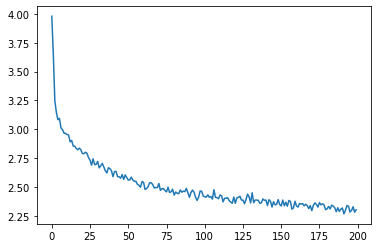

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

#### Sampling the network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the `EOS` token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string output_name with the starting letter
* Up to a maximum output length,
  * Feed the current letter to the network
  * Get the next letter from highest output, and next hidden state
  * If the letter is EOS, stop here
  * If a regular letter, add to output_name and continue
* Return the final name


> Rather than having to give it a starting letter, another strategy would have been to include a “start of string” token in training and have the network choose its own starting letter.

In [49]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
  with torch.no_grad():  # no need to track history in sampling
    category_t = category_tensor(category)
    input = input_tensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn(category_t, input[0], hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1: #eos
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = input_tensor(letter)

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
      print(sample(category, start_letter))

samples('Russian', 'RUS')


Rovell
Uakin
Shillin


In [50]:
samples('German', 'GER')

Gerte
Eren
Rour


In [51]:
samples('Spanish', 'SPA')


Saler
Palla
Alan


In [52]:
samples('Chinese', 'CHI')

Cha
Han
Ian


### Ref

* [pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)